In [1]:
import os, sys
os.environ['R_HOME'] = sys.exec_prefix + '/lib/R/'
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scFates as scf
import anndata as ad
import matplotlib.pyplot as plt

In [2]:
geo = 'GSE229103'
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_unzip = os.path.join(pth_data, 'unzip', geo)
pth_out = os.path.join(pth_data, 'processed')
pth_fig = os.path.join(pth, 'figures', 'preprocessing')

In [3]:
df_summary = pd.read_csv(os.path.join(pth_data, 'summary.csv'))
df_summary = df_summary.loc[df_summary.Source == geo]
df_summary

,Source,Name,Study,Species,Trajectory,Age,Description
3,GSE229103,Neuromesodermal Progenitor,"Jin et al., 2025",mmusculus,True,E8.5,Developmental dataset describing bipotent neur...


In [4]:
adata1 = sc.read_10x_mtx(pth_unzip, prefix = 'GSM7152484_JHW1_')
adata2 = sc.read_10x_mtx(pth_unzip, prefix = 'GSM7152485_JHW3_')
adata = ad.concat({'embryo_rep1' : adata1, 'embryo_rep2' : adata2}, label = 'sample')
adata.obs_names_make_unique(); adata

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 48694 × 32286
    obs: 'sample'

In [5]:
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells = 3)

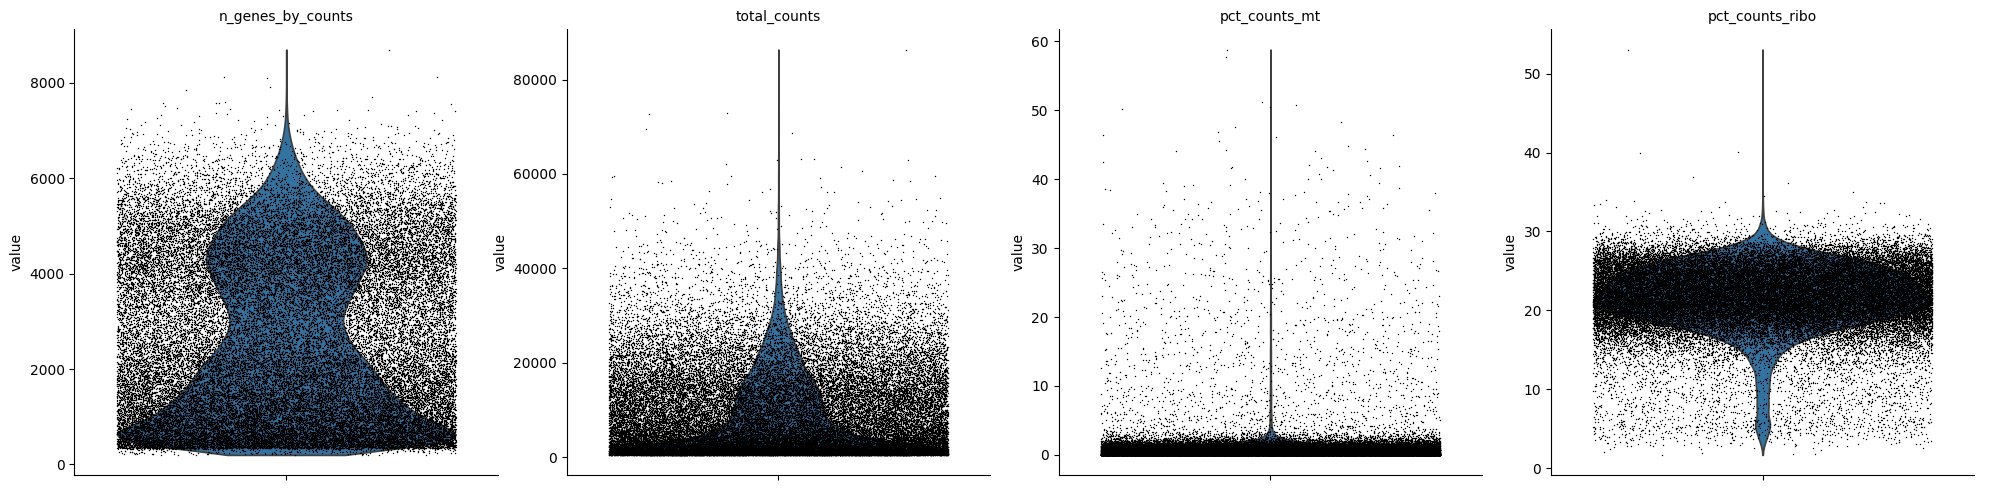

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata.var['ribo'] = adata.var_names.str.startswith(('Rps', 'Rpl'))
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt', 'ribo'], percent_top = None, inplace = True, log1p = False)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], jitter = .4, multi_panel = True)

In [7]:
adata = adata[
    (adata.obs.total_counts >= 10000) &
    (adata.obs.total_counts <= 50000) &
    (adata.obs.pct_counts_mt <= 2.5) &
    (adata.obs.pct_counts_ribo <= 25) &
    (adata.obs.n_genes_by_counts >= 3000)]
adata

View of AnnData object with n_obs × n_vars = 16097 × 21592
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Finding overdispersed features
    computing mean and variances
    gam fitting
    found 3199 over-dispersed features (0:00:03) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



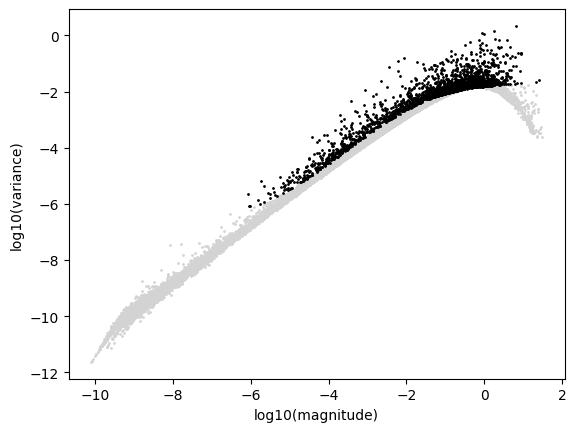

In [8]:
sc.pp.normalize_total(adata, target_sum = 10000)
sc.pp.log1p(adata)
sc.pp.filter_genes(adata, min_cells = 3)
scf.pp.find_overdispersed(adata, plot = True)

In [9]:
sc.pp.pca(adata)
sce.pp.harmony_integrate(adata, 'sample')

2025-10-13 17:58:01,983 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-10-13 17:58:05,347 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-10-13 17:58:05,505 - harmonypy - INFO - Iteration 1 of 10
2025-10-13 17:58:10,478 - harmonypy - INFO - Iteration 2 of 10
2025-10-13 17:58:15,446 - harmonypy - INFO - Iteration 3 of 10
2025-10-13 17:58:20,330 - harmonypy - INFO - Iteration 4 of 10
2025-10-13 17:58:25,169 - harmonypy - INFO - Iteration 5 of 10
2025-10-13 17:58:28,040 - harmonypy - INFO - Iteration 6 of 10
2025-10-13 17:58:29,870 - harmonypy - INFO - Iteration 7 of 10
2025-10-13 17:58:31,497 - harmonypy - INFO - Iteration 8 of 10
2025-10-13 17:58:33,102 - harmonypy - INFO - Iteration 9 of 10
2025-10-13 17:58:34,693 - harmonypy - INFO - Converged after 9 iterations


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


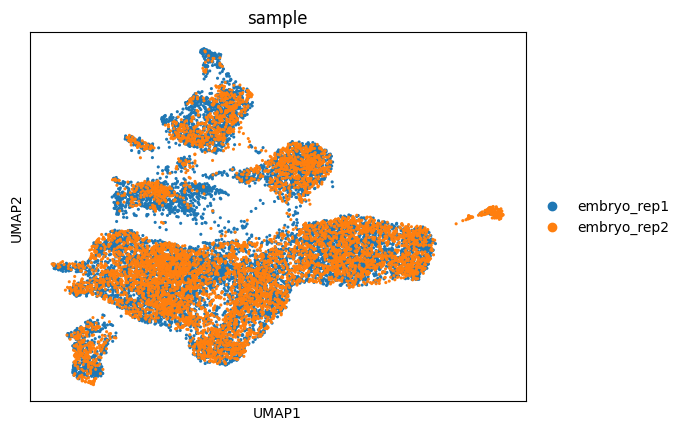

In [10]:
sc.pp.neighbors(adata, n_pcs = 30, use_rep = 'X_pca_harmony')
sc.tl.umap(adata)
sc.pl.umap(adata, color = 'sample', size = 20)

/tmp/ipykernel_3721707/799754552.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = .5)


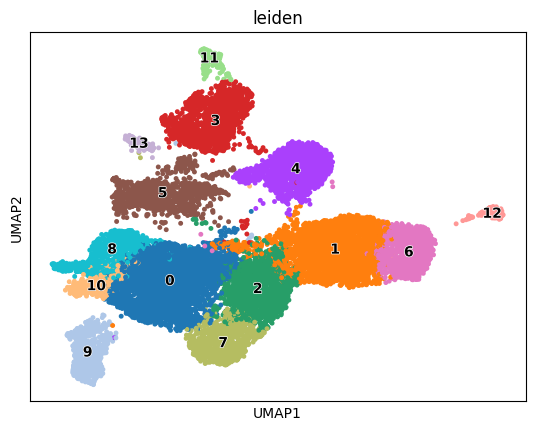

In [11]:
sc.tl.leiden(adata, resolution = .5)
sc.pl.umap(adata, color = 'leiden', size = 50, legend_loc = 'on data', legend_fontoutline = True)

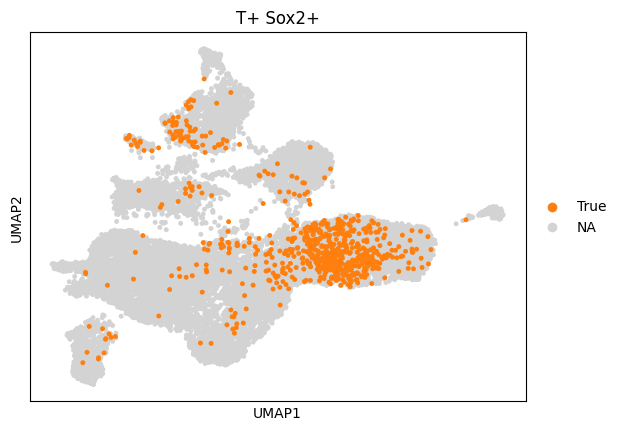

In [12]:
adata.obs['T+ Sox2+'] = np.all(adata[:, ['T', 'Sox2']].X.toarray() > 0, axis = 1).astype(str)
sc.pl.umap(adata, color = 'T+ Sox2+', size = 50, groups = ['True'])

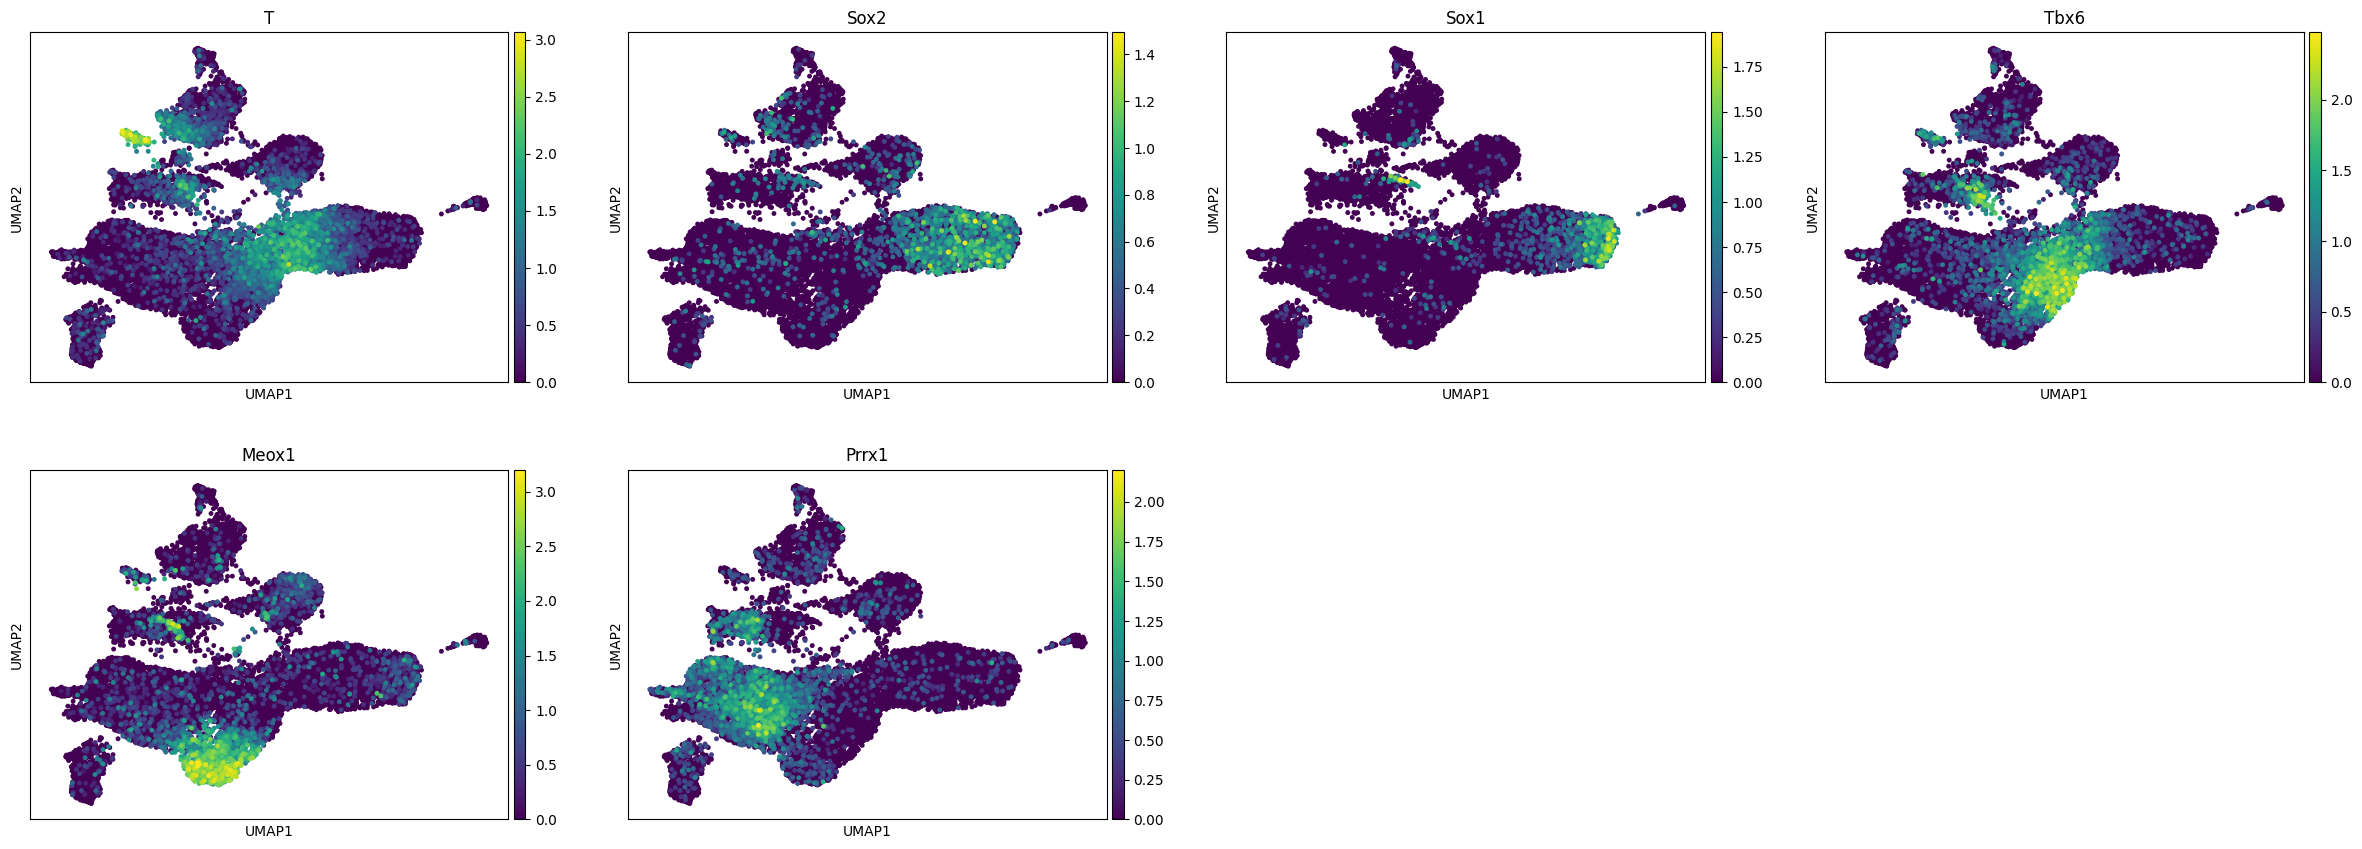

In [14]:
sc.pl.umap(adata, color = ['T', 'Sox2', 'Sox1', 'Tbx6', 'Meox1', 'Prrx1'], size = 50)

In [15]:
keep = np.array([6, 1, 2, 7, 0], dtype = str)
adata = adata[adata.obs.leiden.isin(keep), :].copy()
adata

AnnData object with n_obs × n_vars = 9788 × 21072
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden', 'T+ Sox2+'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'sample_colors', 'leiden', 'leiden_colors', 'T+ Sox2+_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

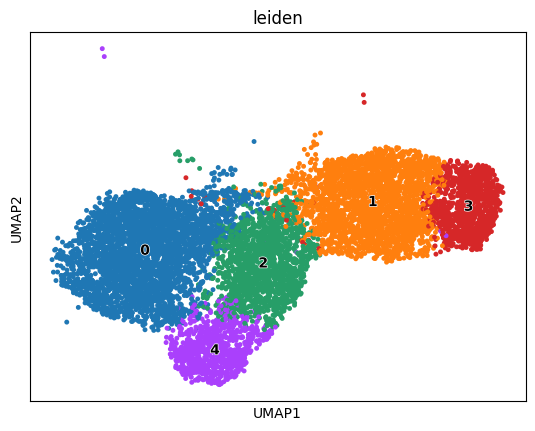

In [30]:
sc.tl.leiden(adata, resolution = .3)
sc.pl.umap(adata, color = 'leiden', size = 50, legend_loc = 'on data', legend_fontoutline = True)

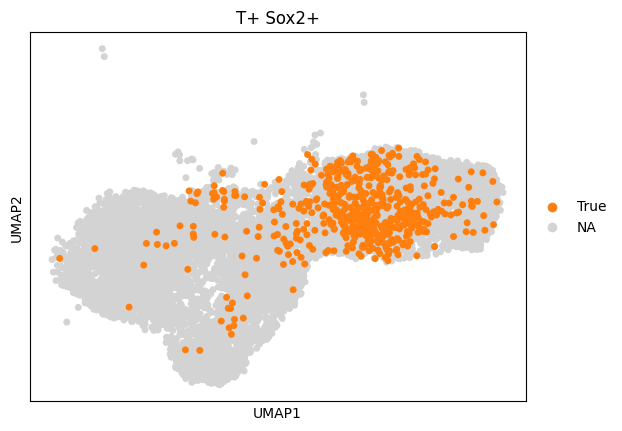

In [28]:
sc.pl.umap(adata, color = 'T+ Sox2+', size = 100, groups = ['True'])

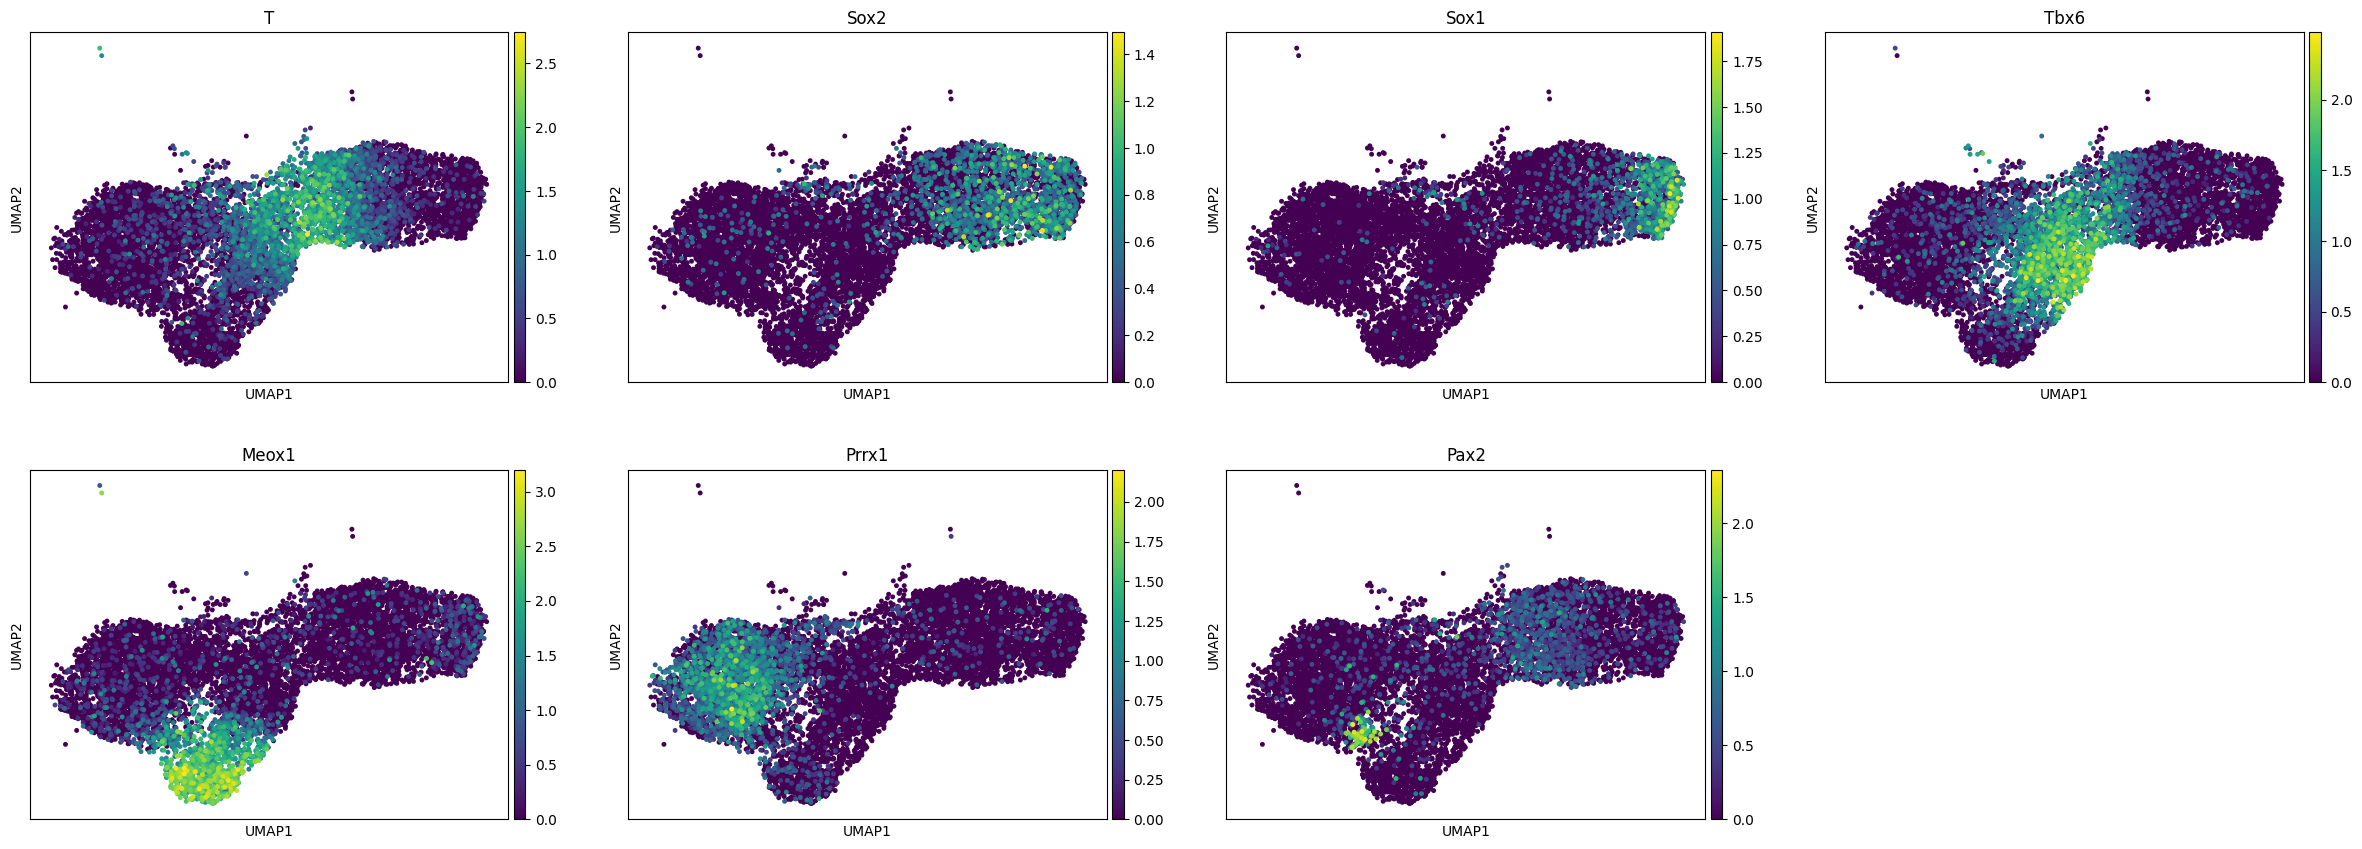

In [29]:
sc.pl.umap(adata, color = ['T', 'Sox2', 'Sox1', 'Tbx6', 'Meox1', 'Prrx1', 'Pax2'], size = 50)

In [31]:
celltype_dict = {
    '0' : 'Mixed Mesoderm',
    '1' : 'Neuromesodermal Progenitor',
    '2' : 'Presomitic Mesoderm',
    '3' : 'Neural Tube',
    '4' : 'Somite'}

adata.obs['celltype'] = adata.obs.leiden.map(celltype_dict).astype('category')

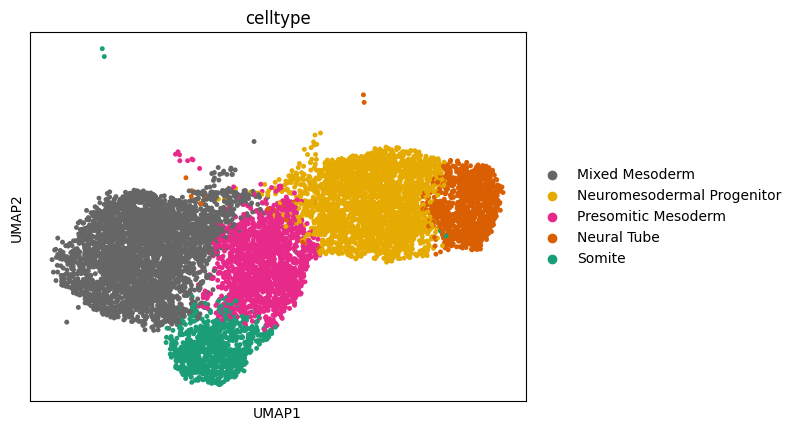

In [38]:
sc.pl.umap(adata, color = 'celltype', size = 50, palette = 'Dark2_r')

In [39]:
adata.write(os.path.join(pth_out, f'{geo}.h5ad'))

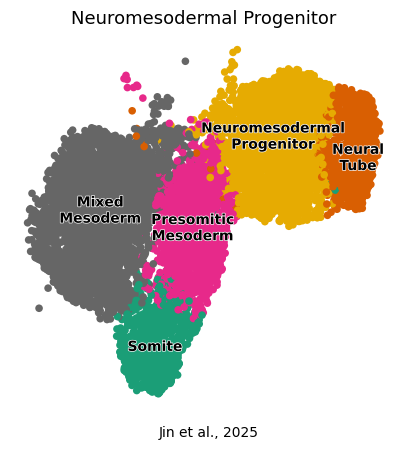

In [42]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
sc.pl.umap(adata, color = 'celltype', size = 120,
           legend_loc = 'on data', na_in_legend = False,
           legend_fontoutline = 1, frameon = False,
           show = False, ax = ax)
ax.set_ylim(top = ax.get_ylim()[1] - 4)

label_dict = {'Neuromesodermal Progenitor' : 'Neuromesodermal\nProgenitor',
              'Neural Tube'                : 'Neural\nTube',
              'Presomitic Mesoderm'        : 'Presomitic\nMesoderm',
              'Mixed Mesoderm'             : 'Mixed\nMesoderm'}

pos_dict = {'Neuromesodermal Progenitor' : (-.25, .25),
            'Neural Tube'                : (.25, -.25)}

for label in ax.texts:
    _label_ = label.get_text()
    x, y = label.get_position()
    if _label_ in label_dict:
        label.set_text(label_dict[_label_])
    if _label_ in pos_dict:
        dx, dy = pos_dict[_label_]
        label.set_position([x + dx, y + dy])

ax.set_title(df_summary.Name.values[0], size = 13)
ax.text(.385, -.05, df_summary.Study.values[0], transform = ax.transAxes)
fn = os.path.join(pth_fig, 'processed', f'{geo}.pdf')
plt.savefig(fn, bbox_inches = 'tight')